In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from google.colab import files

#import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])



# Download and load the training data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [ ]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [ ]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.convolutaional_neural_network_layers = nn.Sequential(

                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28)

                nn.MaxPool2d(kernel_size=2),


                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),

                nn.MaxPool2d(kernel_size=2)

        )

        # Linear layer
        self.linear_layers = nn.Sequential(

                nn.Linear(in_features=24*7*7, out_features=64),
                nn.ReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(in_features=64, out_features=10)
        )

    # Defining the forward pass
    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)

        x = x.view(x.size(0), -1)

        x = self.linear_layers(x)

        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
model = Network()
model.to(device)
print(model)

Network(
  (convolutaional_neural_network_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 10 # The total number of iterations

train_losses = []
test_losses = []

for epoch in range(epochs):
    # prep model for training
    model.train()
    train_loss = 0

    for idx, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    else:
        # prep model for evaluation
        model.eval()
        test_loss = 0
        accuracy = 0


        with torch.no_grad():
            for images, labels in testloader:

                images = images.to(device)
                labels = labels.to(device)

                log_probabilities = model(images)
                test_loss += criterion(log_probabilities, labels)

                probabilities = torch.exp(log_probabilities)
                top_prob, top_class = probabilities.topk(1, dim=1)
                predictions = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(predictions.type(torch.FloatTensor))

        train_losses.append(train_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}  ".format(epoch+1, epochs),
              "Training loss: {:.4f}  ".format(train_loss/len(trainloader)),
              "Testing loss: {:.4f}  ".format(test_loss/len(testloader)),
              "Test accuracy: {:.4f}  ".format(accuracy/len(testloader)))

Epoch: 1/10   Training loss: 0.7518   Testing loss: 0.2561   Test accuracy: 0.9177  
Epoch: 2/10   Training loss: 0.2565   Testing loss: 0.1687   Test accuracy: 0.9502  
Epoch: 3/10   Training loss: 0.1838   Testing loss: 0.1153   Test accuracy: 0.9652  
Epoch: 4/10   Training loss: 0.1462   Testing loss: 0.1014   Test accuracy: 0.9697  
Epoch: 5/10   Training loss: 0.1207   Testing loss: 0.0858   Test accuracy: 0.9730  
Epoch: 6/10   Training loss: 0.1046   Testing loss: 0.0668   Test accuracy: 0.9780  
Epoch: 7/10   Training loss: 0.0928   Testing loss: 0.0632   Test accuracy: 0.9795  
Epoch: 8/10   Training loss: 0.0849   Testing loss: 0.0599   Test accuracy: 0.9809  
Epoch: 9/10   Training loss: 0.0795   Testing loss: 0.0545   Test accuracy: 0.9821  
Epoch: 10/10   Training loss: 0.0725   Testing loss: 0.0493   Test accuracy: 0.9831  


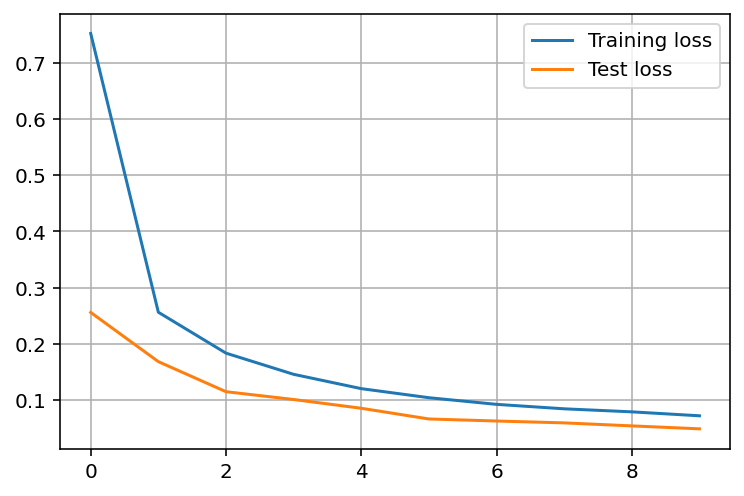

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.grid()

In [ ]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)


with torch.no_grad():
    logits = model.forward(img)

torch.Size([1, 1, 28, 28])


In [ ]:
# save the model
torch.save(model.state_dict(), 'cnn_mnist.pth')

# download checkpoint file
files.download('cnn_mnist.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>